In this tutorial, we verify the phase diagram shown in Supplementary information of PRL **111** 067203 (2013).

In [1]:
using MicroMagnetic
using CairoMakie
using NPZ

@using_gpu()

function relax_system(; H=0.2, T=5)
    mesh = CubicMesh(; nx=28 * 3, ny=16 * 5, nz=1, pbc="xy")

    sim = Sim(mesh; driver="LLG", name="skx", integrator="RungeKutta")
    sim.driver.alpha = 0.1
    sim.driver.gamma = 1.76e11
    sim.driver.integrator.step = 1e-15
    set_mu_s(sim, mu_s_1)

    init_m0_random(sim)

    J = 50 * k_B
    add_exch(sim, J; name="exch")
    add_dmi(sim, 0.5 * J; name="dmi")

    Hz = H * J / mu_s_1
    add_zeeman(sim, (0, 0, Hz))
    add_thermal_noise(sim, J / k_B * T)

    for _ in 1:Int(5e4)
        advance_step(sim)
    end

    #save_vtk(sim, "Skx_H_$H-T_$T")
    Q = compute_skyrmion_number(Array(sim.spin), mesh)

    return Q
end

function compute_Qs()
    Qs = Float64[]
    for i in 0:8, j in 0:10
        H = 0.05 * i
        T = 0.05 * j
        Q = relax_system(; H=H, T=T)
        print("H=$H, T=$T, Q=$Q\n")
        push!(Qs, Q)
    end
    return Qs
end

if !isfile("assets/Qs.npy")
    Qs = compute_Qs()
    npzwrite("assets/Qs.npy", Qs)
end

We plot the phase diagram using the following script.

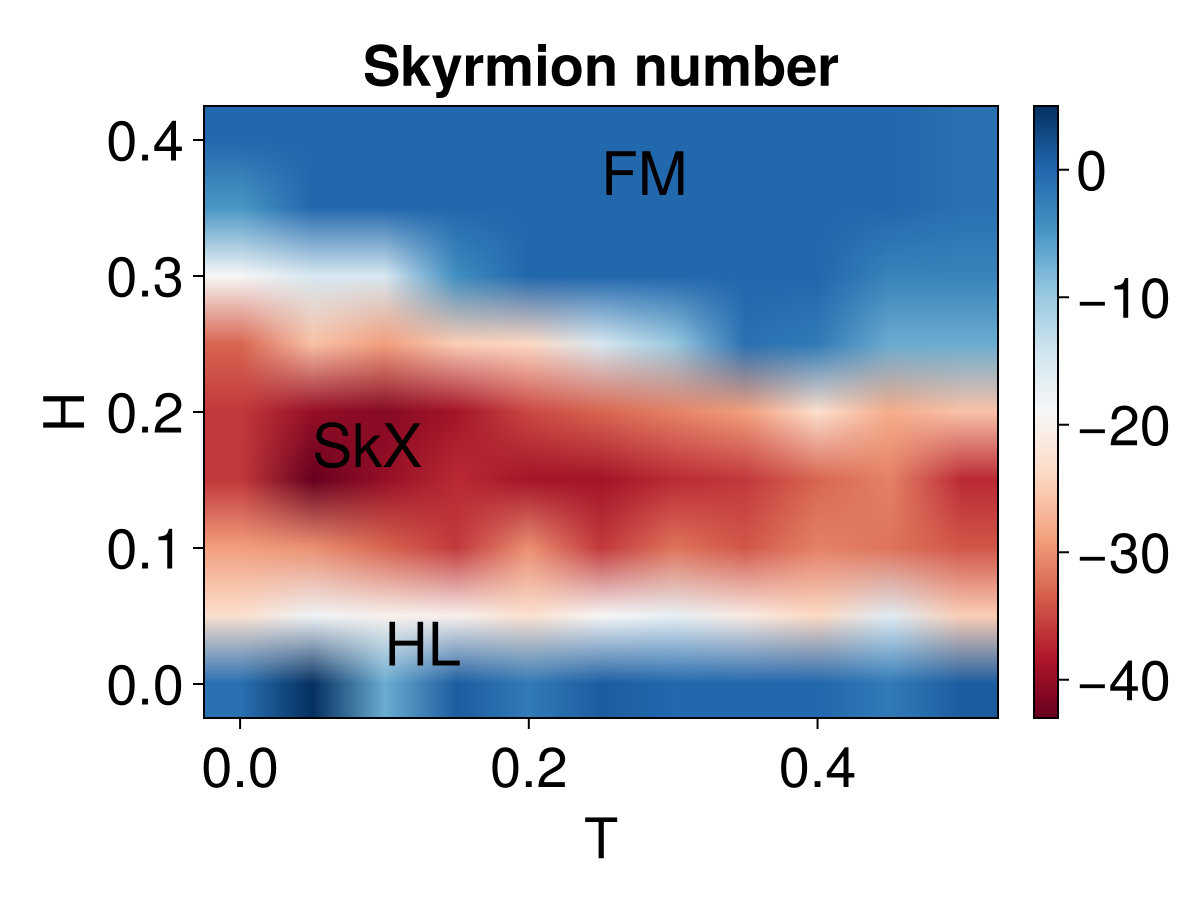

In [2]:
function plot_phase_diagram()
    Qs = npzread("assets/Qs.npy")

    Hs = [0.05 * i for i in 0:8]
    Ts = [0.05 * i for i in 0:10]
    Qs = reshape(Qs, (length(Ts), length(Hs)))

    fig = Figure(; figsize=(800, 600), fontsize=28)
    ax = Axis(fig[1, 1]; title="Skyrmion number", xlabel="T", ylabel="H")

    hm = heatmap!(ax, Ts, Hs, Qs; interpolate=true, colormap=:RdBu)
    Colorbar(fig[:, end + 1], hm)
    text!(ax, 0.25, 0.35; text="FM", fontsize=30)
    text!(ax, 0.05, 0.15; text="SkX", fontsize=30)
    text!(ax, 0.1, 0.004; text="HL", fontsize=30)
    return fig
end

plot_phase_diagram()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*